# QC2: Remove low quality cells

2025-07-22

## Remove low-quality cells

Removing low-quality cells is crucial for downstream analysis steps.
Each dataset has its own QC thresholds, and these thresholds should be determined based on reasonable evidence.
If you encounter any low-quality cells during downstream analysis, re-run the QC with adjusted thresholds!

We obtained SingleCellExperiment (SCE) objects without estimated droplets from the previous section.
In this section, we will remove low-quality cells that have large mitochondrial proportions, low RNA content, or low numbers of detected genes.

In [1]:
library(DropletUtils)
library(dplyr)
library(scater)

set.seed(42) # for reproducibility

save_path = "QC2"

Warning message:
“package ‘DropletUtils’ was built under R version 4.3.2”
Loading required package: SingleCellExperiment

Warning message:
“package ‘SingleCellExperiment’ was built under R version 4.3.2”
Loading required package: SummarizedExperiment

Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.3.2”
Loading required package: SingleCellExperiment

Warning message:
“package ‘SingleCellExperiment’ was built under R version 4.3.2”
Loading required package: SummarizedExperiment

Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.3.2”
Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.3”
Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”
Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.3”
Loading required package: matrixStats

Warning message:
“p

### Load droplet-filtered SCE objects

In [ ]:
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_1.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_2.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_3.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_4.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_5.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_6.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_7.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_8.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_9.RData")
load(file = "/BiO/data/process/QC2_data/DropletUtils_filtered_sce_12.RData")

### Process a single sample as an example

A SCE object contains:
- a gene-by-cell counts as a sparse matrix
- gene data (gene annotation, etc)
- cell data (sample information, experimental condition information, etc). 

Gene and cell informations are stored in `rowData(SCE)` and `colData(SCE)`, respectively. Here, Ensembl gene ids are translated into gene symbol for easier further analysis.

Since there are 10 samples, we will process an example sample step-by-step and make a function `preprocess()` to apply the same process to other samples.

The example SCE object is shown below.

In [3]:
sce <- DropletUtils_rawsce_5
sce

class: SingleCellExperiment 
dim: 36604 4096 
metadata(1): Samples
assays(1): counts
rownames(36604): ENSG00000243485 ENSG00000237613 ... Htag2 Htag3
rowData names(3): ID Symbol Type
colnames(4096): AAACCCACATCCTAAG-1 AAACCCATCAAGCTGT-1 ...
  TTTGTTGGTGGGATTG-1 TTTGTTGTCTTCGACC-1
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

To remove low quality cells, we use the `addPerCellQC()` function from the `scater` R package. This function calculates several quality control (QC) metrics for each cell, including:
- number of unique molecular identifiers (UMIs) per cell
- number of genes detected per cell
- percentage of UMIs assigned to mitochondrial (MT) genes

In [5]:
rownames(sce) <- uniquifyFeatureNames(rowData(sce)$ID, rowData(sce)$Symbol)

mtgenes <- rowData(sce)[grep("^MT-", rowData(sce)$Symbol),]$Symbol
is.mito <- rownames(sce) %in% mtgenes
print(table(is.mito))

is.mito
FALSE  TRUE 
36591    13 


In [6]:
sce <- addPerCellQC(
  sce,
  subsets = list(MT=mtgenes),
  percent_top = c(50, 100, 200, 500), 
  detection_limit = 5
)

sce$log10_sum = log10(sce$sum + 1)
sce$log10_detected = log10(sce$detected + 1)

sce <- sce[,sce$sum!=0]

We define low-quality cells with:
-  &lt;500 UMIs
-  &gt;15% MT gene percents
-  &lt;100 detected genes

Criteria is visualized as histogram below.

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)

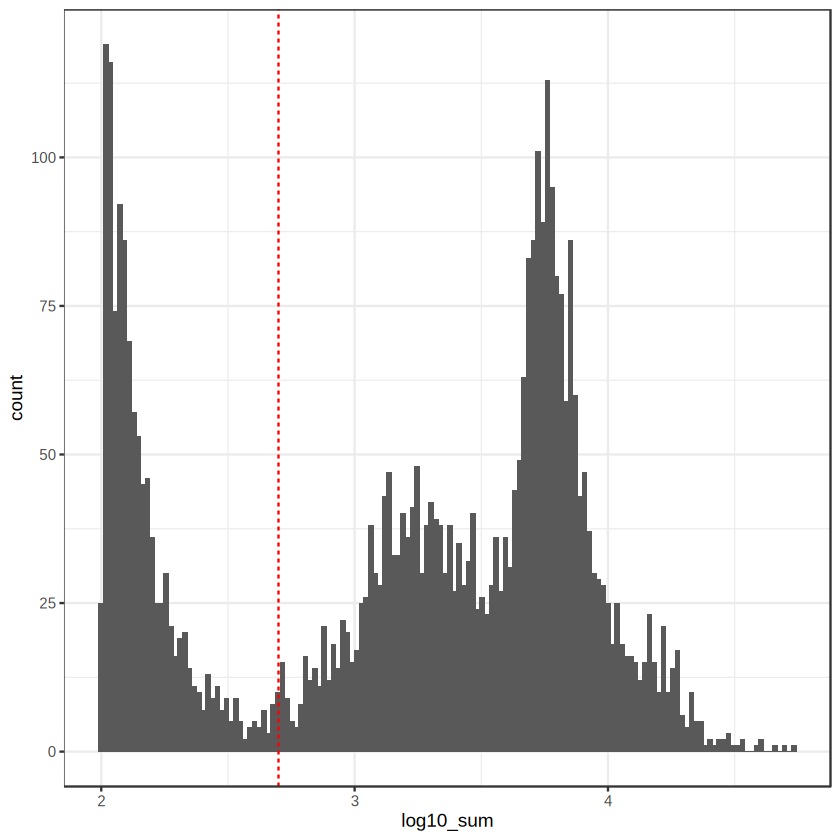

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


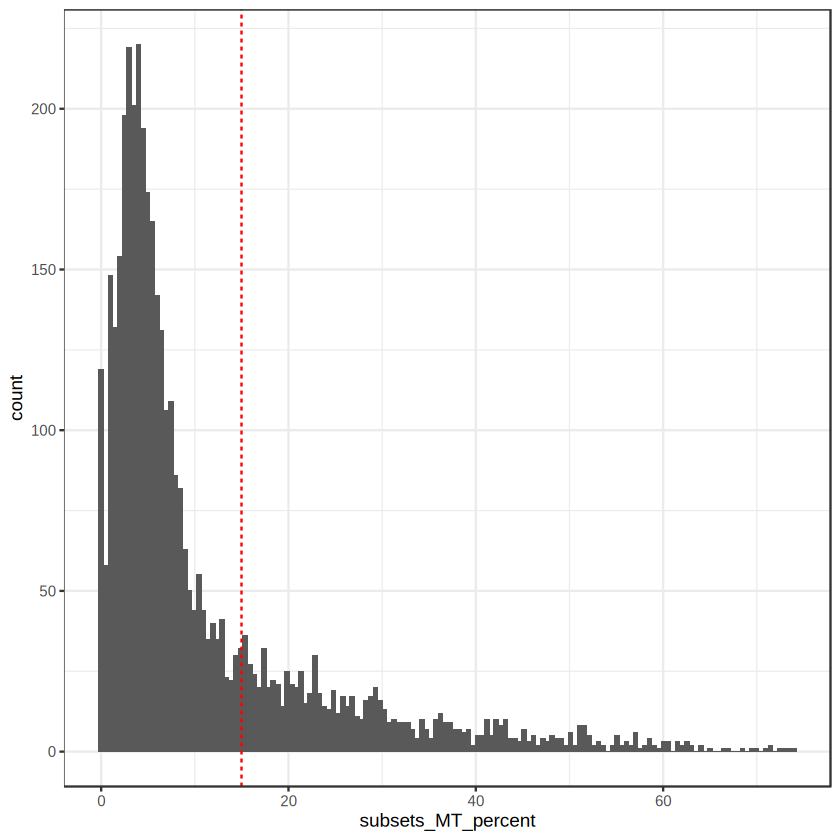

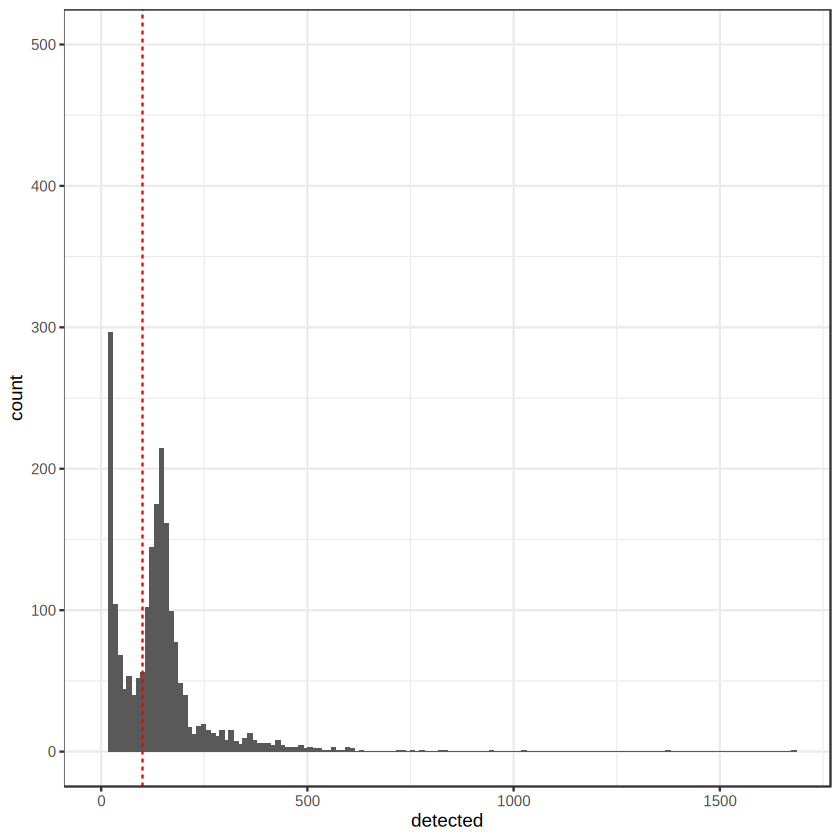

In [7]:
umi <- 500
mtpct <- 15
detect <- 100

ggplot(data.frame(colData(sce)), aes(x = log10_sum)) + 
  geom_histogram(bins = 150) +
  theme_bw() +
  geom_vline(xintercept = log10(umi), color="red", linetype="dashed")
  
ggplot(data.frame(colData(sce)), aes(x = subsets_MT_percent)) + 
  geom_histogram(bins = 150) +
  theme_bw() +
  geom_vline(xintercept = mtpct, color="red", linetype="dashed")

ggplot(data.frame(colData(sce)), aes(x = detected)) + 
  geom_histogram(bins = 150) +
  theme_bw() +
  geom_vline(xintercept = detect, color="red", linetype="dashed") + 
  ylim(0, 500)


Low-quality cells being filtered out can be identified by the PCA plot.

In [17]:
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res=200)

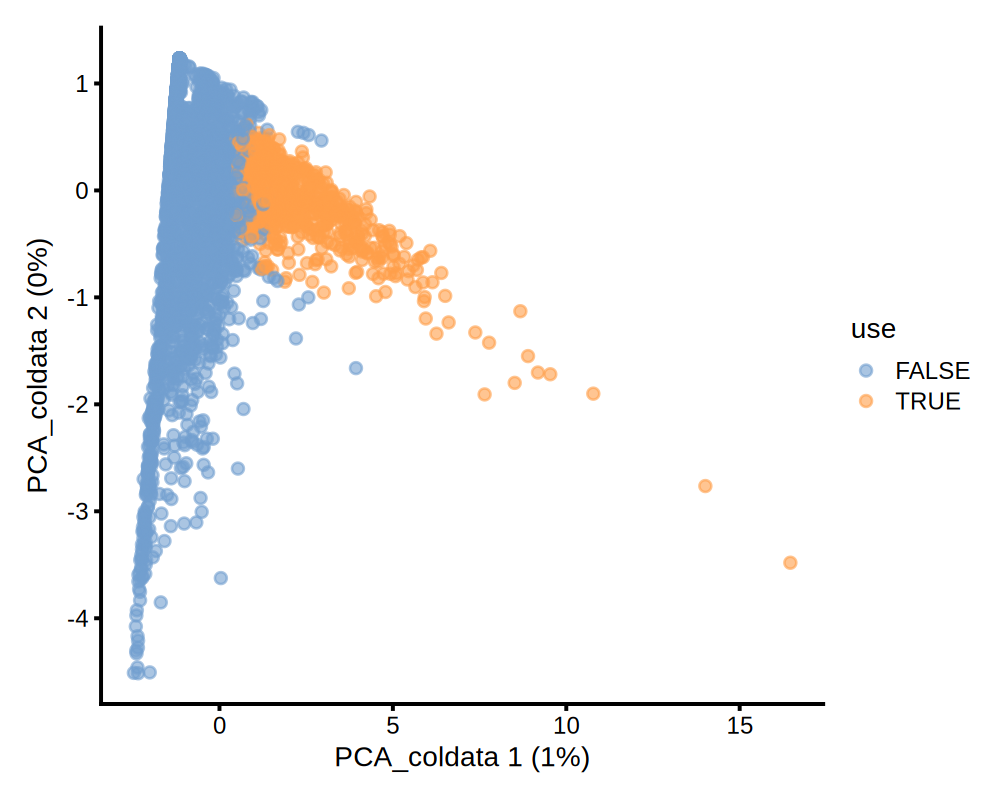

In [18]:
filter_by_total_counts <- sce$sum > umi
filter_by_mt_percent <- sce$subsets_MT_percent < mtpct
filter_by_nfeature <- sce$detected > detect

sce <- runColDataPCA(sce, variables = list("sum", "detected", "subsets_MT_percent", "percent.top_500"))

sce$use <- (
  filter_by_total_counts &
    filter_by_mt_percent &
    filter_by_nfeature
)

plotReducedDim(sce, dimred="PCA_coldata", colour_by="use") +
  theme(plot.margin = margin(10, 10, 10, 10))


In [19]:
sce <- sce[,sce$use]
sce

class: SingleCellExperiment 
dim: 36604 1350 
metadata(1): Samples
assays(1): counts
rownames(36604): MIR1302-2HG FAM138A ... Htag2 Htag3
rowData names(3): ID Symbol Type
colnames(1350): AAACCCATCTGAACGT-1 AAACGAACAAGAGAGA-1 ...
  TTTGGTTGTCGCTCGA-1 TTTGTTGGTGGGATTG-1
colData names(15): Sample Barcode ... log10_detected use
reducedDimNames(1): PCA_coldata
mainExpName: NULL
altExpNames(0):

### Process other samples
Other samples can be processed in the same way, and it's baked into a function `preprocess()` below.

In [20]:
preprocess <- function(sce){
  rownames(sce) <- uniquifyFeatureNames(rowData(sce)$ID, rowData(sce)$Symbol)
  
  mtgenes <- rowData(sce)[grep("^MT-", rowData(sce)$Symbol),]$Symbol
  is.mito <- rownames(sce) %in% mtgenes
  
  sce <- addPerCellQC(
    sce,
    subsets = list(MT=mtgenes),
    percent_top = c(50, 100, 200, 500), 
    detection_limit = 5
  )
  
  sce$log10_sum <- log10(sce$sum + 1)
  sce$log10_detected <- log10(sce$detected + 1)
  
  sce <- sce[, sce$sum!=0]
  return(sce)
}

filtering <- function(sce,umi,mtpct,detect){
  filter_by_total_counts <- sce$sum > umi
  filter_by_mt_percent <- sce$subsets_MT_percent < mtpct
  filter_by_nfeature <- sce$detected > detect
  
  sce <- runColDataPCA(sce, variables = list("sum", "detected", "subsets_MT_percent", "percent.top_500"))
  
  sce$use <- (
    filter_by_total_counts &
      filter_by_mt_percent &
      filter_by_nfeature
  )
  
  plotReducedDim(sce, dimred="PCA_coldata", colour_by="use")
  
  sce <- sce[, sce$use]
  return(sce)
}

In [22]:
umi <- 500
mtpct <- 15
detect <- 100

sce.1 <- preprocess(DropletUtils_rawsce_1)
sce.1 <- filtering(sce.1, umi, mtpct, detect)

sce.2 <- preprocess(DropletUtils_rawsce_2)
sce.2 <- filtering(sce.2, umi, mtpct, detect)

sce.3 <- preprocess(DropletUtils_rawsce_3)
sce.3 <- filtering(sce.3, umi, mtpct, detect)

sce.4 <- preprocess(DropletUtils_rawsce_4)
sce.4 <- filtering(sce.4, umi, mtpct, detect)

sce.5 <- preprocess(DropletUtils_rawsce_5)
sce.5 <- filtering(sce.5, umi, mtpct, detect)

sce.6 <- preprocess(DropletUtils_rawsce_6)
sce.6 <- filtering(sce.6, umi, mtpct, detect)

sce.7 <- preprocess(DropletUtils_rawsce_7)
sce.7 <- filtering(sce.7, umi, mtpct, detect)

sce.8 <- preprocess(DropletUtils_rawsce_8)
sce.8 <- filtering(sce.8, umi, mtpct, detect)

sce.9 <- preprocess(DropletUtils_rawsce_9)
sce.9 <- filtering(sce.9, umi, mtpct, detect)

sce.12 <- preprocess(DropletUtils_rawsce_12)
sce.12 <- filtering(sce.12, umi, mtpct, detect)

### Change cellbarcode name
Each cell has their own cellbarcode. To prevent errors due to the presence of the duplicate cellbarcode across samples, we will append the sample information to the cellbarcode. 

Currently, cellbarcode from the first sample looks like below.

In [33]:
print(head(colnames(sce.1)))

[1] "AAACCCAAGGGTGAAA-L1" "AAACCCATCAGTCTTT-L1" "AAACGAAGTGCGGATA-L1"
[4] "AAACGAATCGTAACTG-L1" "AAACGCTGTCTCACGG-L1" "AAAGGATTCGTGTCAA-L1"


In [24]:
colnames(sce.1) <- paste0(substring(colnames(sce.1),1,16),"-L1")
colnames(sce.2) <- paste0(substring(colnames(sce.2),1,16),"-L2")
colnames(sce.3) <- paste0(substring(colnames(sce.3),1,16),"-L3")
colnames(sce.4) <- paste0(substring(colnames(sce.4),1,16),"-L4")
colnames(sce.5) <- paste0(substring(colnames(sce.5),1,16),"-L5")
colnames(sce.6) <- paste0(substring(colnames(sce.6),1,16),"-L6")
colnames(sce.7) <- paste0(substring(colnames(sce.7),1,16),"-L7")
colnames(sce.8) <- paste0(substring(colnames(sce.8),1,16),"-L8")
colnames(sce.9) <- paste0(substring(colnames(sce.9),1,16),"-L9")
colnames(sce.12) <- paste0(substring(colnames(sce.12),1,16),"-L12")

After appending the sample information, the cellbarcode will look like below.

In [32]:
print(head(colnames(sce.1)))

[1] "AAACCCAAGGGTGAAA-L1" "AAACCCATCAGTCTTT-L1" "AAACGAAGTGCGGATA-L1"
[4] "AAACGAATCGTAACTG-L1" "AAACGCTGTCTCACGG-L1" "AAAGGATTCGTGTCAA-L1"


### Adding sample information as metadata

For downstream analysis, we will combine all SCE objects add metadata about their conditions (`CONTROL`, `ASYMPTOMATIC` or `SYMPTOMATIC`)



In [28]:
sce <- cbind(sce.1, sce.2, sce.3, sce.4, sce.5, sce.6, sce.7, sce.8, sce.9, sce.12)
sce$library <- "NA"
sce$library[grep("20094_0001_A_B", sce$Sample)] <- "L1"
sce$library[grep("20094_0002_A_B", sce$Sample)] <- "L2"
sce$library[grep("20094_0003_A_B", sce$Sample)] <- "L3"
sce$library[grep("20094_0004_A_B", sce$Sample)] <- "L4"
sce$library[grep("20094_0005_A_B", sce$Sample)] <- "L5"
sce$library[grep("20094_0006_A_B", sce$Sample)] <- "L6"
sce$library[grep("20094_0007_A_B", sce$Sample)] <- "L7"
sce$library[grep("20094_0008_A_B", sce$Sample)] <- "L8"
sce$library[grep("20094_0009_A_B", sce$Sample)] <- "L9"
sce$library[grep("20094_0012_A_B", sce$Sample)] <- "L12"

table(sce$library)


  L1  L12   L2   L3   L4   L5   L6   L7   L8   L9 
1823 3293 2166 1835  833 1350  324  419 1345  678 

In [29]:
sce$Condition <- "SYMPTOMATIC"
sce$Condition[sce$library == "L12"] <- "CONTROL"
sce$Condition[sce$library %in% c("L4","L5","L6")] <- "ASYMPTOMATIC"

table(sce$Condition)


ASYMPTOMATIC      CONTROL  SYMPTOMATIC 
        2507         3293         8266 

## References

Butler, A., Hoffman, P., Smibert, P., Papalexi, E. & Satija, R. Integrating single-cell transcriptomic data across different conditions, technologies, and species. Nat. Biotechnol. 36, 411-420 (2018).

McCarthy, D. J., Campbell, K. R., Lun, A. T. & Wills, Q. F. Scater: pre-processing, quality control, normalization and visualization of single-cell RNA-seq data in R. Bioinformatics 33, 1179-1186 (2017).

Pekayvaz, K., Leunig, A., Kaiser, R. et al. Protective immune trajectories in early viral containment of non-pneumonic SARS-CoV-2 infection. Nat Commun 13, 1018 (2022).

In [30]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.2 LTS

Matrix products: default
BLAS/LAPACK: /BiO/prog/miniforge3/envs/QC/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Seoul
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scater_1.30.1               ggplot2_3.5.2              
 [3] scuttle_1.12.0              dplyr_1.1.4                
 [5] DropletUtils_1.22.0         SingleCellExperiment_1.24.0
 [7] SummarizedExperiment_1.32.0 Biob